# Initial Imports

In [1]:
import argparse, sys, os, logging
import numpy as np
import pandas as pd
import powergrid_data
from hmmlearn import hmm
from datetime import datetime
from scipy import stats, special
from pandas.tools.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler, normalize
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, WeekdayLocator, DayLocator, HourLocator, AutoDateLocator, DateFormatter, AutoDateFormatter, date2num
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from analysis import analyzer
import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

# Test and Train Files Directory

In [2]:
train = 'data/train/train.csv'
test = 'data/test/test_v1.csv'

# Train Model

In [3]:
power_grid = powergrid_data.datasets(train, test)

In [4]:
def pointAnomalyAnalyzer(power_grid, fullYear=None, fullMonth=[None], fullDay=None, threshold=1, n_comp=3):

    analyze = analyzer(power_grid)

    dates_columns = 'DateTime'
    features_columns = ['Global_active_power']

    analyze.time_series(dates_columns, features_columns)


    ## If you modify year, month and day, make sure the above dates_columns is either Date or DateTime

    ## Both test and train has data of year 2006, 2007 and 2008
    Year = fullYear

    ## Months takes a string of month full name e.g 'March'
    Month = fullMonth
    Day = fullDay

    ## If you modify hour, minutes and seconds, make sure the above dates_columns is either DateTime or Time
    ## Hour uses 24 hr clock
    Hour = None
    Minutes = None
    Seconds = None

    train_dates, train_features, test_dates, test_features = analyze.parser(year = Year, month = Month, day = Day, hour = Hour, minutes = Minutes, seconds = Seconds)


    # Make an HMM instance and execute fit

    init_probability = np.array([0.6, 0.3, 0.1])

    translation_probability = np.array([
        [0.7, 0.2, 0.1],
        [0.3, 0.5, 0.2],
        [0.3, 0.3, 0.4]]
    )

    model = hmm.GaussianHMM(n_components=n_comp, covariance_type="full", tol = 0.1, n_iter=500, init_params="st")
    model.startprob_ = init_probability
    model.transmat_ = translation_probability

    model.fit(train_features)

    train_state_seq = model.sample(test_features.size)[1]
    test_state_seq = model.predict(test_features)

    means = []
    variance = []

    for i in range(model.n_components):
        means.append(model.means_[i].flatten()[0])
        variance.append(model.covars_[i].flatten()[0])

    standard_deviation = np.sqrt(variance)

    anom = []
    notanom = []
    meanStates = []

    test_observation = test_features.values

    # thresholds 0.5, 1, 1.25 ,1.5, 1.75 and 2

    for i in range(test_observation.size):
        state = test_state_seq[i]
        if (np.abs(means[state] - test_observation[i]) <= threshold):
            notanom.append(True)
        else:
            notanom.append(False)
        meanStates.append(means[state])

    test_features_anomaly = np.copy(test_observation)
    test_features_anomaly[notanom] = None

    plt.figure(figsize=(20,10))
    plt.plot(test_dates, test_observation, 'go', markersize=4)
    plt.plot(test_dates, test_features_anomaly, 'ro', markersize=4)





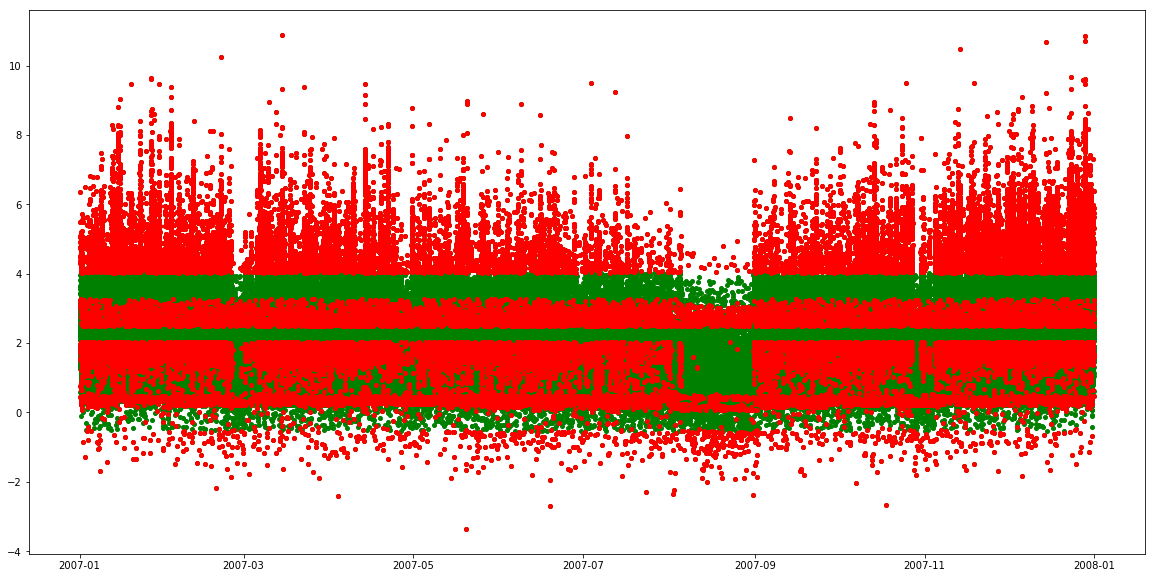

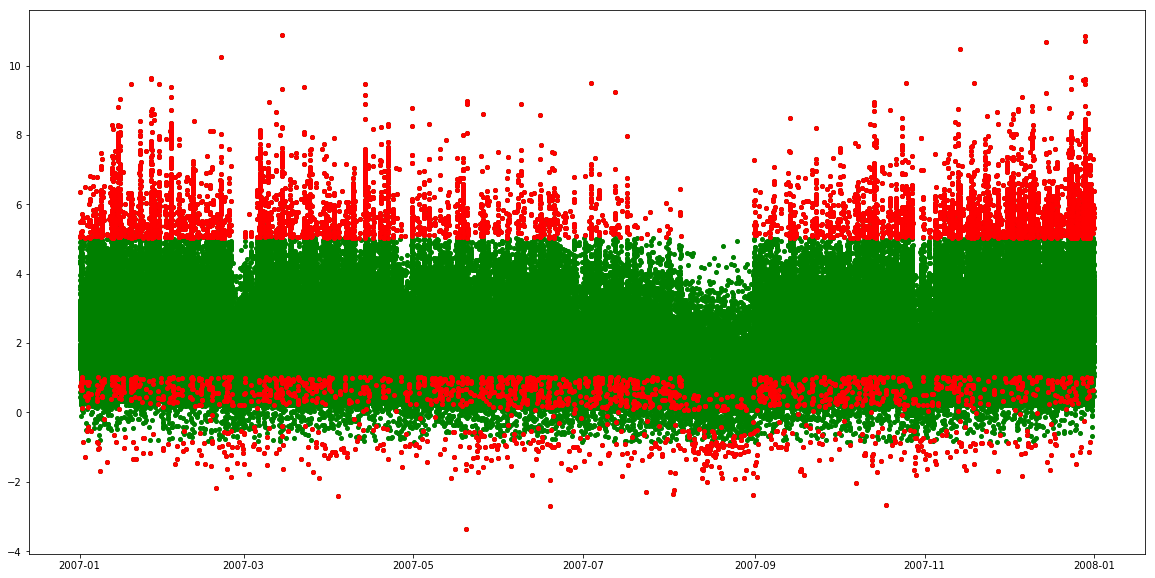

In [5]:
# Full Year 2007
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2007, fullMonth=[None], threshold = 1, n_comp = 3)
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2007, fullMonth=[None], threshold = 2, n_comp = 3)

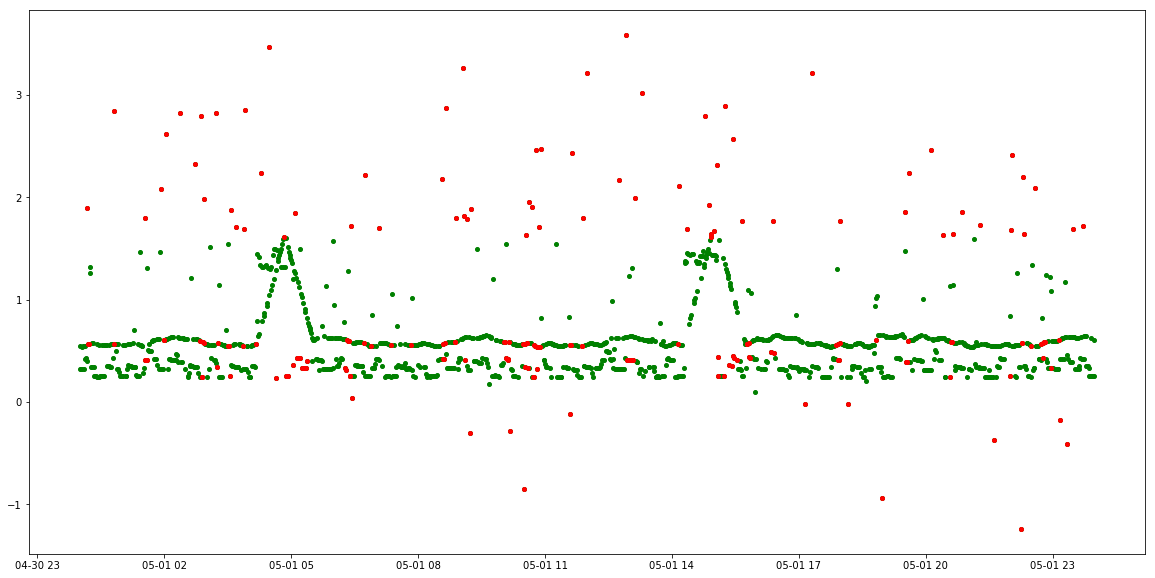

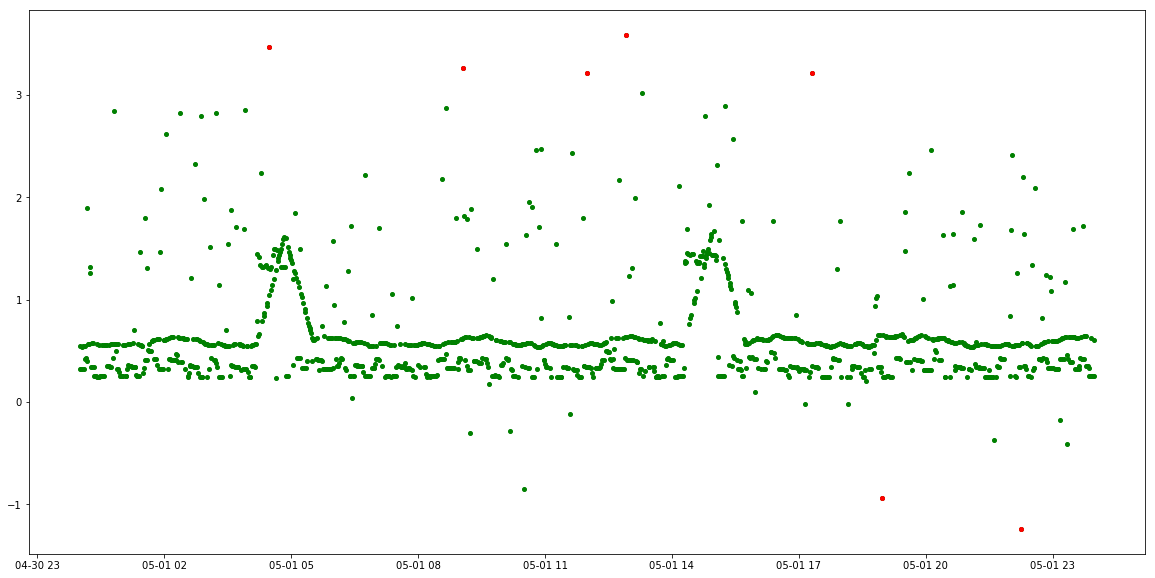

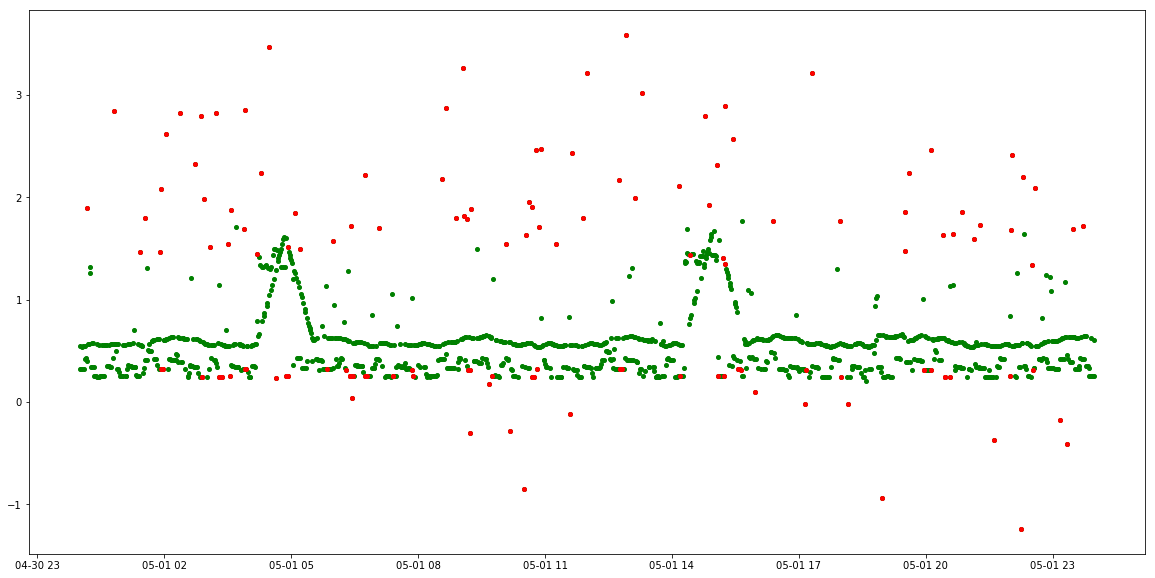

In [6]:
# May 1, 2007
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2007, fullMonth=['May'], fullDay=1, threshold = 0.5, n_comp = 3)
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2007, fullMonth=['May'], fullDay=1, threshold = 2, n_comp = 3)
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2007, fullMonth=['May'], fullDay=1, threshold = 0.5, n_comp = 5)

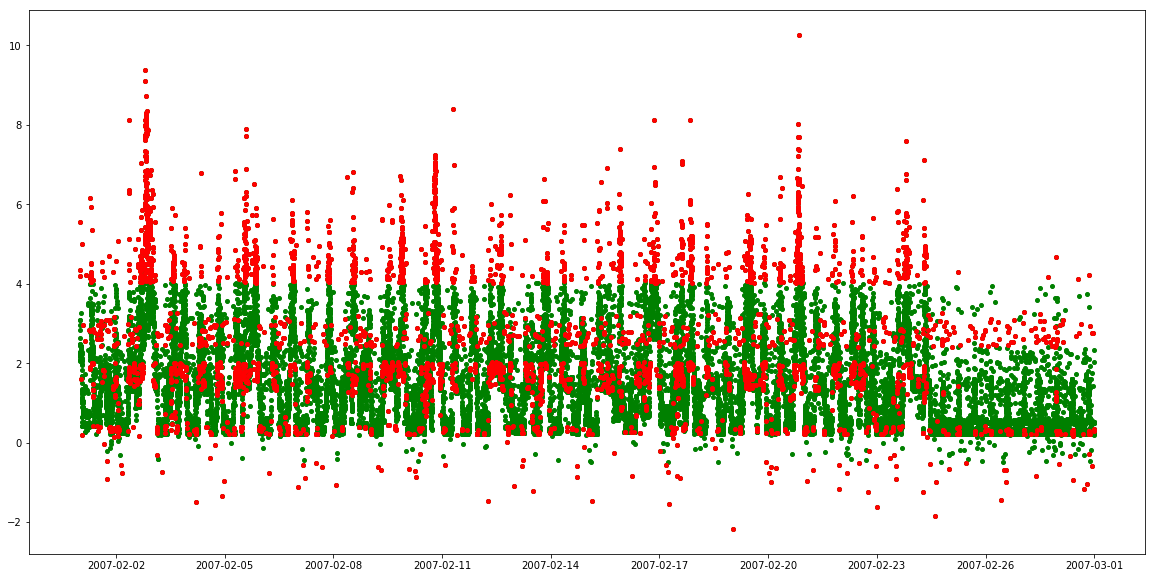

In [7]:
# Last half of Feb 2007
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2007, fullMonth=['February'], threshold = 1, n_comp = 3)

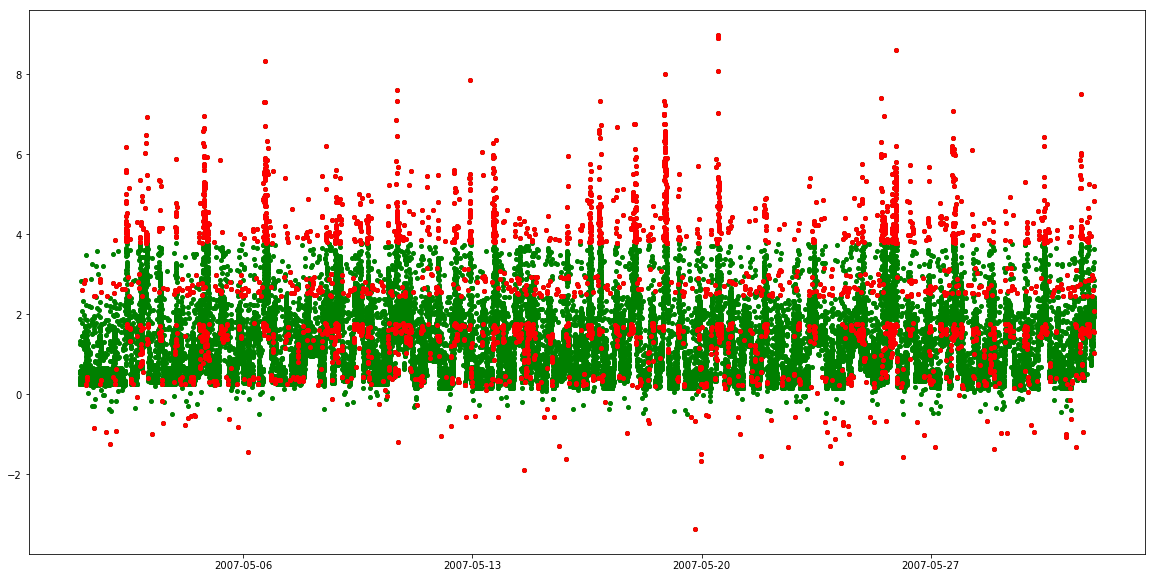

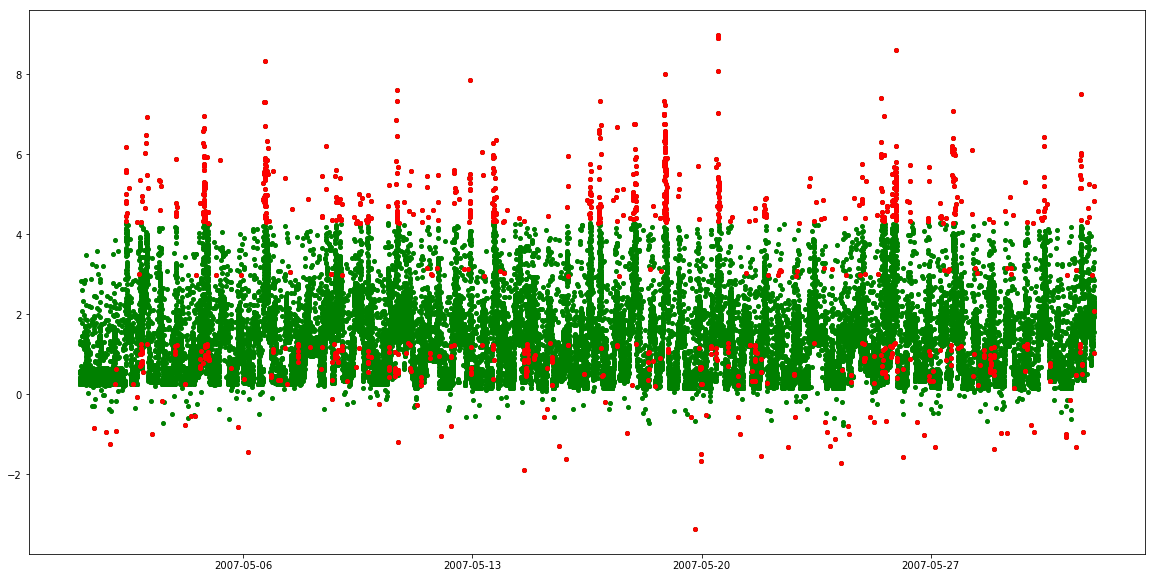

In [8]:
# All of May 2007
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2007, fullMonth=['May'], threshold = 1, n_comp = 3)
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2007, fullMonth=['May'], threshold = 1.5, n_comp = 3)

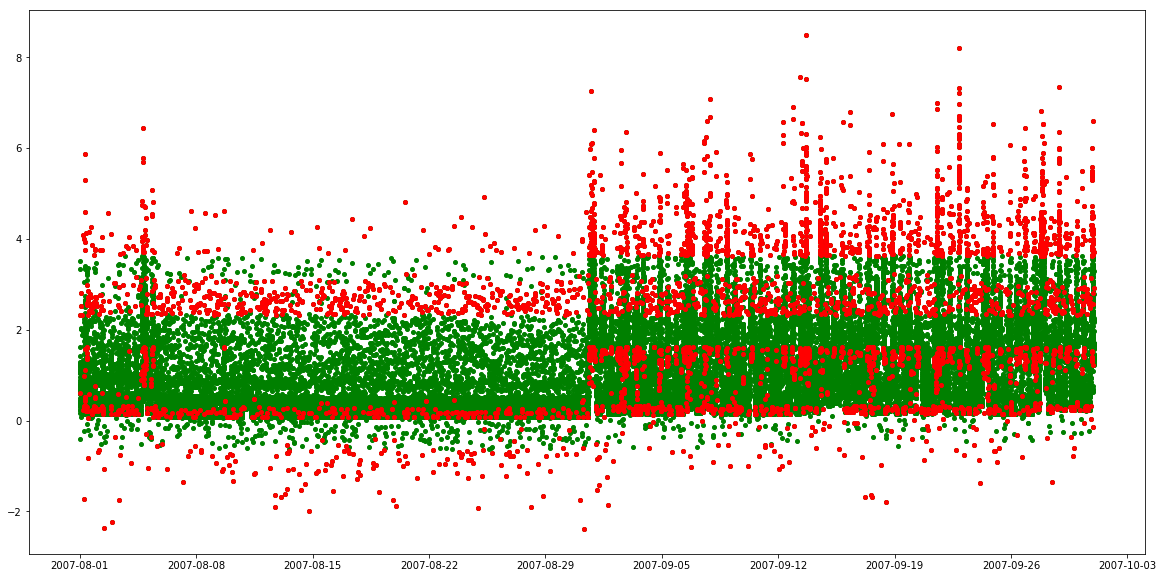

In [9]:
# 2007 August and September
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2007, fullMonth=['August', 'September'], threshold = 1, n_comp = 3)

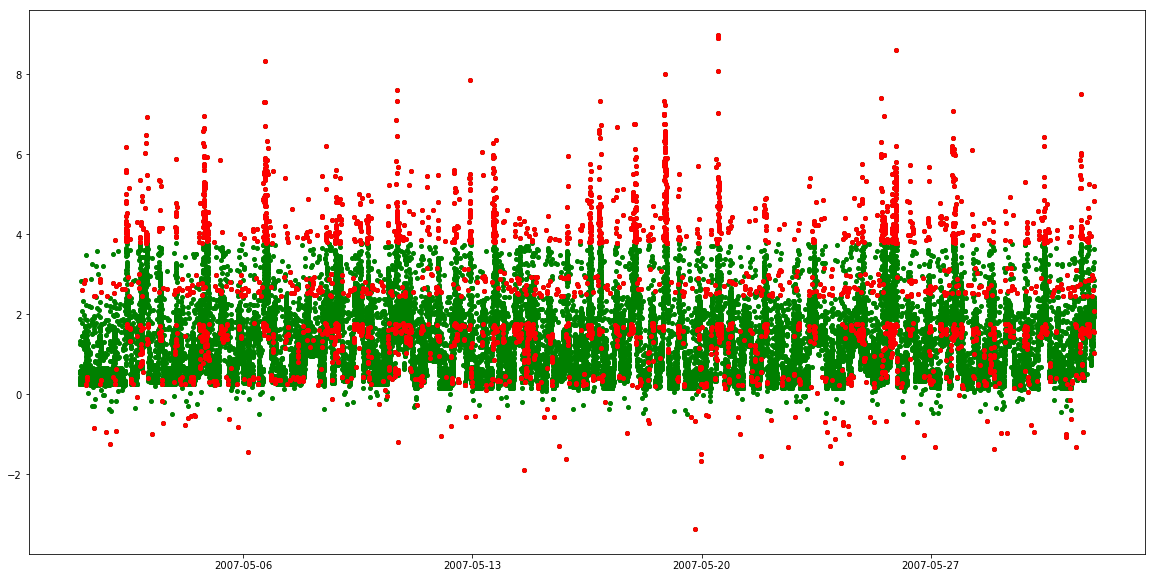

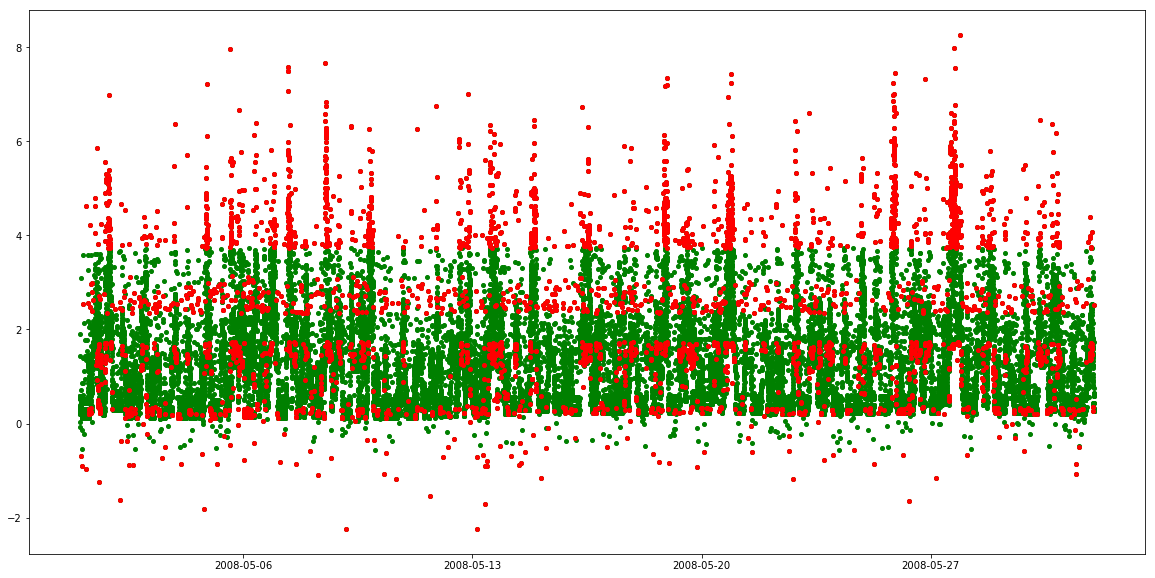

In [10]:
# Month of May 2007 and 2008
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2007, fullMonth=['May'], threshold = 1, n_comp = 3)
pointAnomalyAnalyzer(power_grid=power_grid, fullYear=2008, fullMonth=['May'], threshold = 1, n_comp = 3)